# Compare various stopping conditions

In [42]:
import sys

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

sys.path.append('../src')
import raybay

my_cmap = cm.get_cmap('tab10')
folders = ['SBRT_lung_minsun', 'ZZ_MK_LLungSBRT3778', 'ZZ_MK_RLungSBRT4076',
           'ZZ_MK_RULungSBRT3796', 'ZZ_MK_RLSBRT1931']

## Extract time info from logs

From the plots below, it looks like time info in the log files match the time recorded in the result objects.

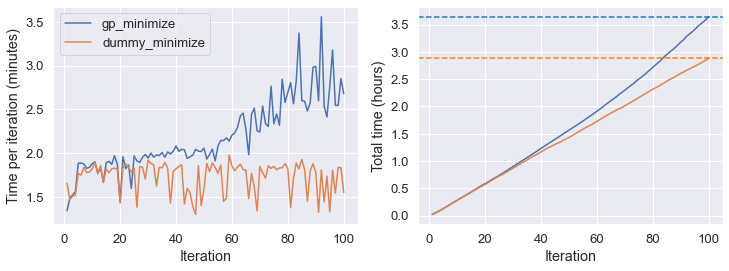

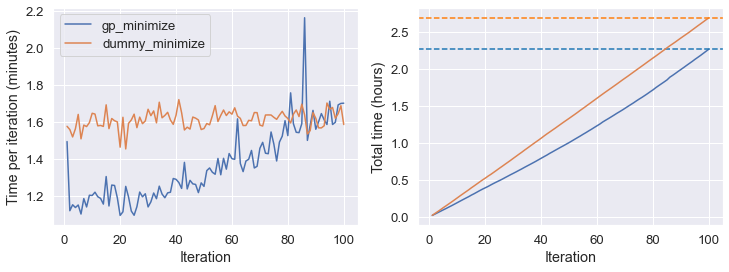

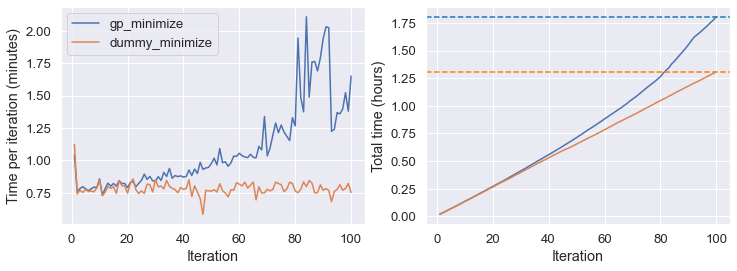

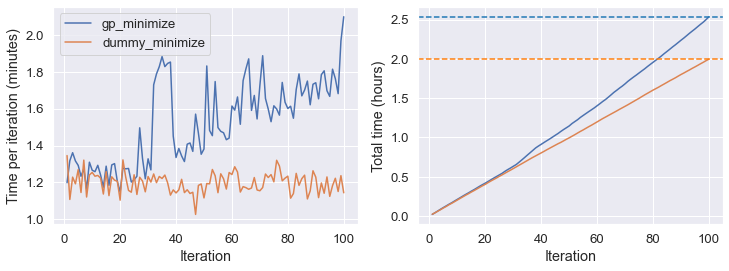

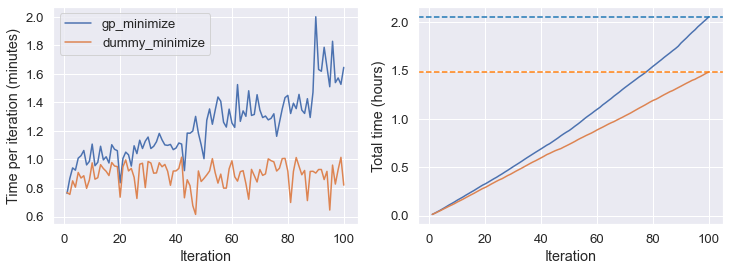

In [43]:
def get_time(folder, method):
    # Load log file
    with open(folder + '/bayes/log_linquad_' + method + '.txt') as f:
        log = f.readlines()

    # Get time info from log
    iter_time = np.zeros(100)
    count = 0
    for row in log:
        if 'Time' in row:
            iter_time[count] = row.split()[-1]
            count += 1

    # Get cumulative time
    total_time = np.cumsum(iter_time)
    return iter_time, total_time

for folder in folders:
    # Initialize plots
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('Time per iteration (minutes)')
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Total time (hours)')
    for ii, method in enumerate(['gp_minimize', 'dummy_minimize']):
        # Load data
        result = np.load(folder + '/bayes/res_linquad_' + method + '.pkl', allow_pickle=True)
        iter_time, total_time = get_time(folder, method)

        # Plot time per iteration
        ax[0].plot(np.arange(1, len(iter_time) + 1), iter_time/60, label=method)

        # Plot total time
        ax[1].plot(np.arange(1, len(total_time) + 1), total_time/3600)
        ax[1].axhline(result.time/3600, color=my_cmap(ii), linestyle='--')
    ax[0].legend()

## Plot utility values

In [44]:
def plot_utility(folder):
    # Load data
    bayes = np.load(folder + '/bayes/res_linquad_gp_minimize.pkl', allow_pickle=True)
    random = np.load(folder + '/bayes/res_linquad_dummy_minimize.pkl', allow_pickle=True)
    
    # Index of best point
    idx_random = np.argmin(random.opt_result.func_vals)
    idx_bayes = np.argmin(bayes.opt_result.func_vals)
    
    # Plot utility values
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(random.opt_result.func_vals, c=my_cmap(0))
    ax[0].plot(bayes.opt_result.func_vals, c=my_cmap(1))
    ax[0].axvline(idx_random, color=my_cmap(0), linestyle=':')
    ax[0].axvline(idx_bayes, color=my_cmap(1), linestyle=':')
                           
    # Plot best utility values
    ax[1].plot(np.minimum.accumulate(random.opt_result.func_vals), c=my_cmap(0))
    ax[1].plot(np.minimum.accumulate(bayes.opt_result.func_vals), c=my_cmap(1))
    ax[1].axvline(idx_random, color=my_cmap(0), linestyle=':')
    ax[1].axvline(idx_bayes, color=my_cmap(1), linestyle=':')
    
    # Annotations
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('Utility')
    ax[0].set_title(folder)
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Best Utility')
    ax[1].set_title(folder)
    ax[1].legend(['Random', 'Bayes'])

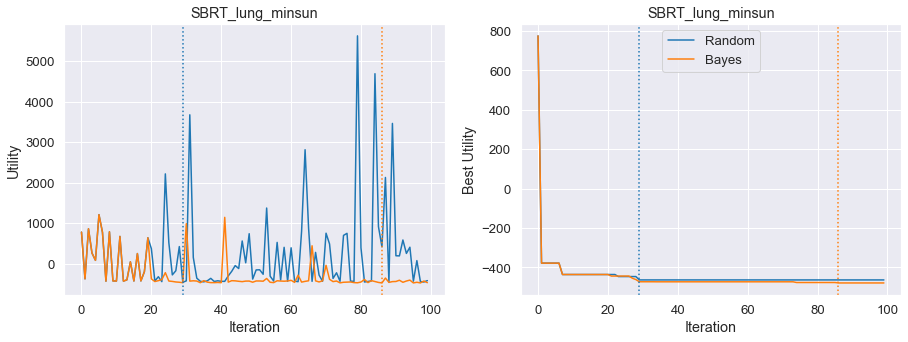

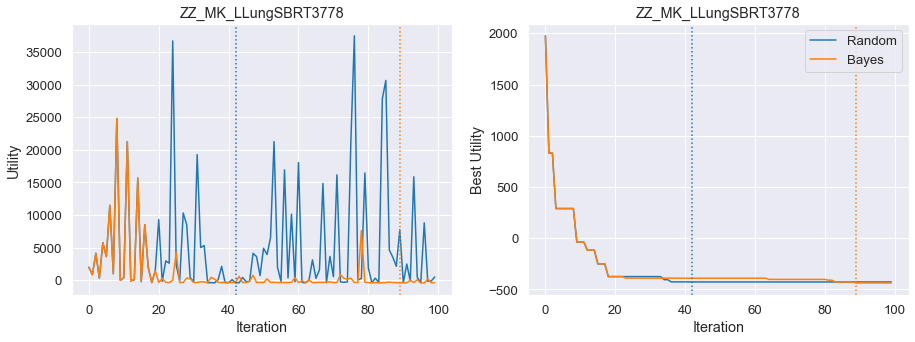

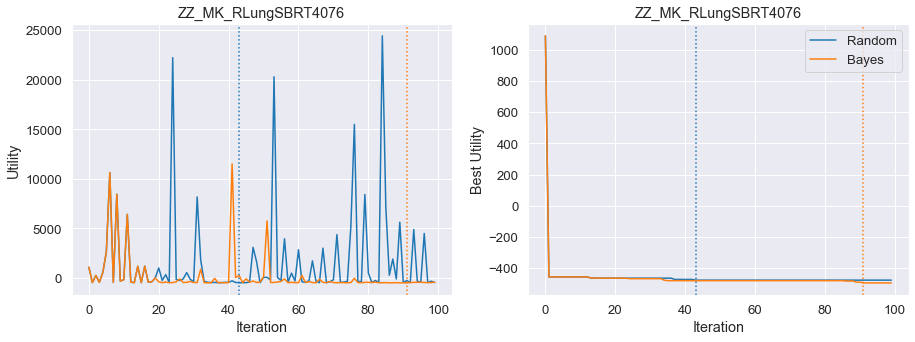

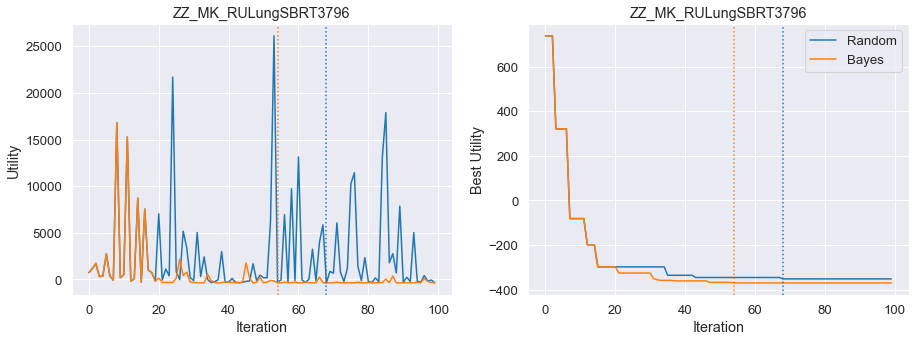

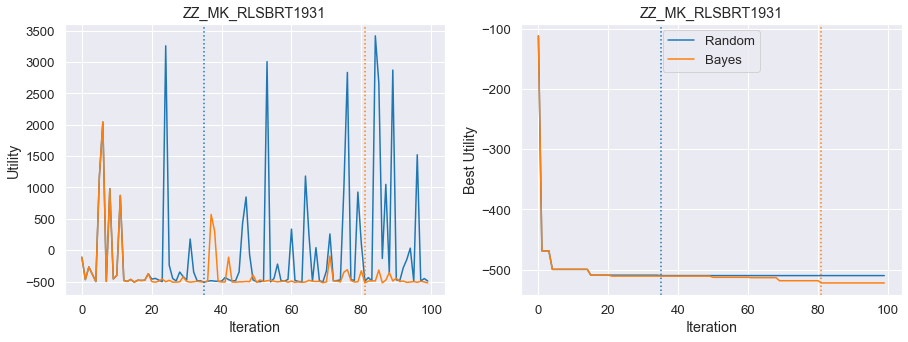

In [45]:
for folder in folders:
    plot_utility(folder)

## Plot difference in utilities and sample points

In [46]:
def get_delta_x(x_iters):
    return [np.linalg.norm(np.array(x_iters[ii]) - np.array(x_iters[ii - 1])) for ii in range(1, len(x_iters))]

def plot_delta(folder):
    # Load data
    bayes = np.load(folder + '/bayes/res_linquad_gp_minimize.pkl', allow_pickle=True)
    random = np.load(folder + '/bayes/res_linquad_dummy_minimize.pkl', allow_pickle=True)
    
    # Index of best point
    idx_random = np.argmin(random.opt_result.func_vals)
    idx_bayes = np.argmin(bayes.opt_result.func_vals)
    
    # Plot difference in utilities
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.diff(random.opt_result.func_vals), c=my_cmap(0))
    ax[0].plot(np.diff(bayes.opt_result.func_vals), c=my_cmap(1))
    ax[0].axvline(idx_random, color=my_cmap(0), linestyle=':')
    ax[0].axvline(idx_bayes, color=my_cmap(1), linestyle=':')
    
    # Plot difference in points
    ax[1].plot(get_delta_x(random.opt_result.x_iters))
    ax[1].plot(get_delta_x(bayes.opt_result.x_iters))
    ax[1].axvline(idx_random, color=my_cmap(0), linestyle=':')
    ax[1].axvline(idx_bayes, color=my_cmap(1), linestyle=':')

    # Annotations
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('Difference in Utility')
    ax[0].set_title(folder)
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Difference in Sample Point')
    ax[1].set_title(folder)
    ax[1].legend(['Random', 'Bayes'])

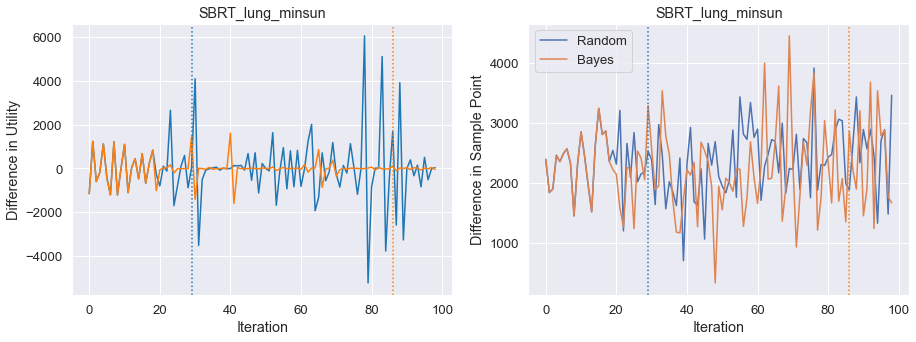

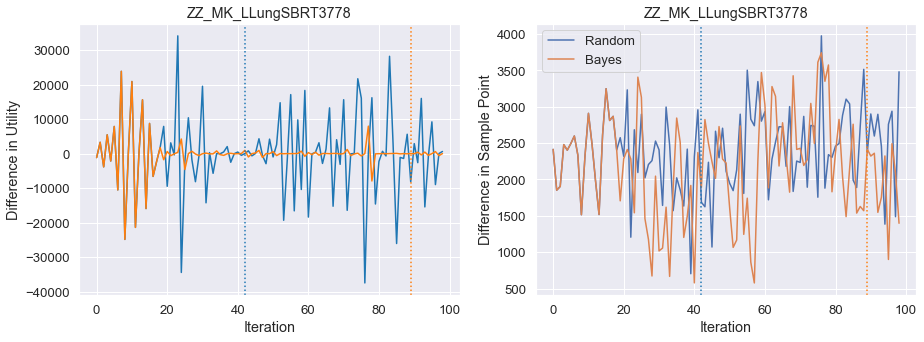

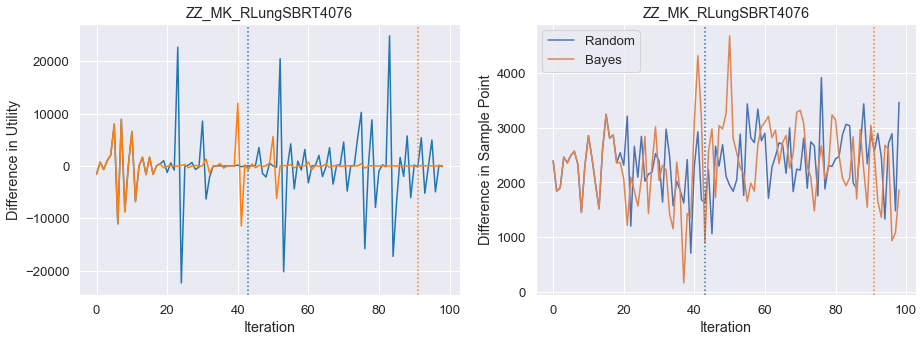

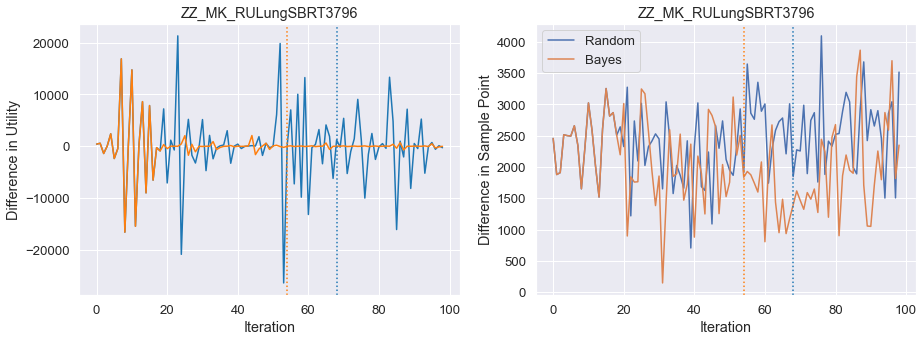

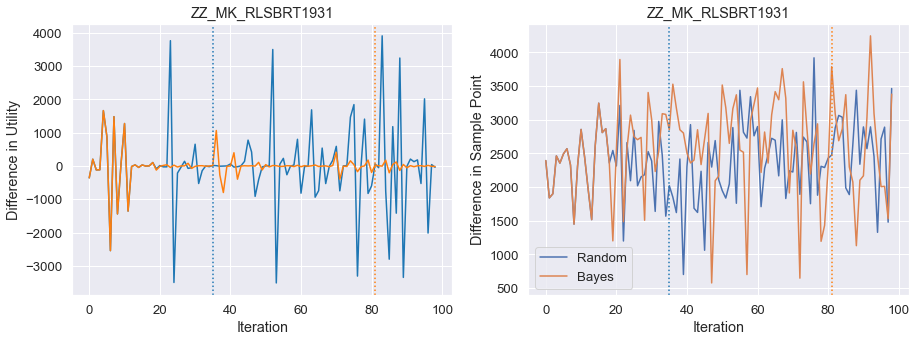

In [47]:
for folder in folders:
    plot_delta(folder)
    
# Left
# * skopt.callbacks.DeltaYStopper(delta, n_best=5)
#   is based on the n_best utilies being within delta,
#   which is different from the `Difference in Utilities` plots
# * however, we could write our own skopt.callbacks.EarlyStopper

# Right
# * skopt.callbacks.DeltaXStopper(delta)
#   is based on difference in sample points: | x1 - x2 | < delta
# * in `Difference in Sample Point`, I'm plotting || x1 - x2 ||_2

## Plot difference between and worst value of 5 best utilities

In [48]:
def get_diff_of_5_min(util_vec):
    result = []
    for ii in range(len(util_vec)):
        sub_vec = util_vec[:ii+1].copy()
        if len(sub_vec) < 5:
            result.append(np.nan)
        else:
            sub_vec.sort()
            sub_vec = sub_vec[:5].copy()
            result.append(max(sub_vec) - min(sub_vec))
    return result

def get_max_of_5_min(util_vec):
    result = []
    for ii in range(len(util_vec)):
        sub_vec = util_vec[:ii+1].copy()
        if len(sub_vec) < 5:
            result.append(np.nan)
        else:
            sub_vec.sort()
            sub_vec = sub_vec[:5].copy()
            result.append(max(sub_vec))
    return result
        
def plot_util_diff(folder):
    # Load data
    bayes = np.load(folder + '/bayes/res_linquad_gp_minimize.pkl', allow_pickle=True)
    random = np.load(folder + '/bayes/res_linquad_dummy_minimize.pkl', allow_pickle=True)
    
    # Index of best point
    idx_random = np.argmin(random.opt_result.func_vals)
    idx_bayes = np.argmin(bayes.opt_result.func_vals)
    
    # Plot difference in best utilities
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(get_diff_of_5_min(random.opt_result.func_vals), c=my_cmap(0))
    ax[0].plot(get_diff_of_5_min(bayes.opt_result.func_vals), c=my_cmap(1))
    ax[0].axvline(idx_random, color=my_cmap(0), linestyle=':')
    ax[0].axvline(idx_bayes, color=my_cmap(1), linestyle=':')
    
    # Plot max of 5 best utility values
    max_random = get_max_of_5_min(random.opt_result.func_vals)
    max_bayes = get_max_of_5_min(bayes.opt_result.func_vals)
    ax[1].plot(max_random, c=my_cmap(0))
    ax[1].plot(max_bayes, c=my_cmap(1))
    ax[1].axvline(idx_random, color=my_cmap(0), linestyle=':')
    ax[1].axvline(idx_bayes, color=my_cmap(1), linestyle=':')

    # Annotations
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('Difference in 5 Best Utilities')
    ax[0].set_title(folder)
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Max of 5 Best Utilites')
    ax[1].set_title(folder)
    ax[1].legend(['Random', 'Bayes'])

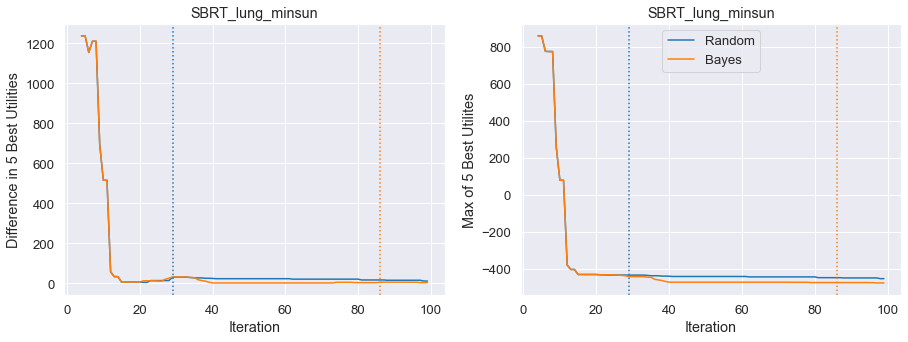

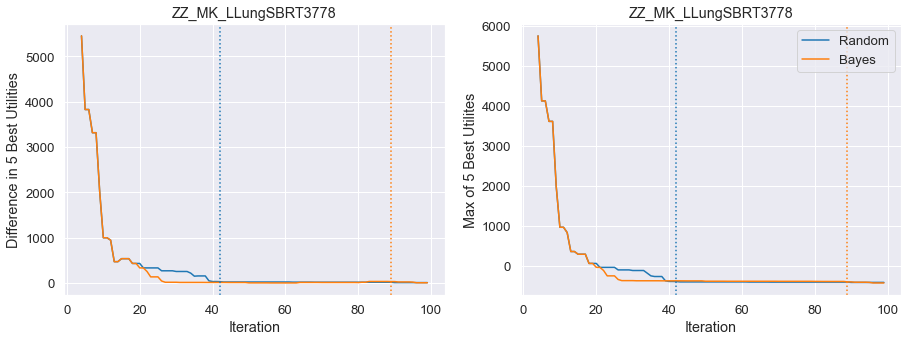

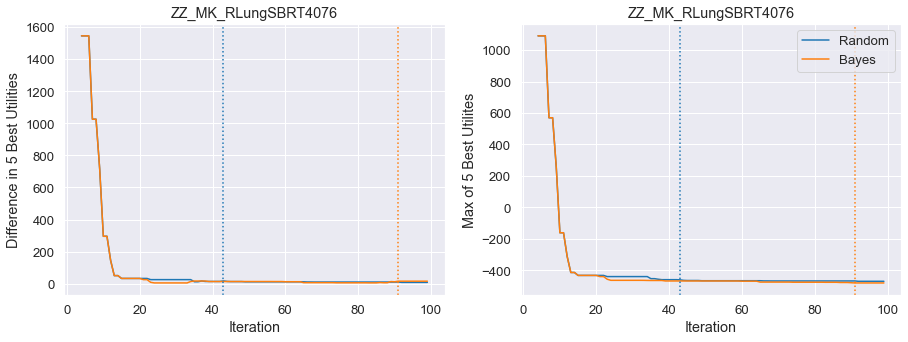

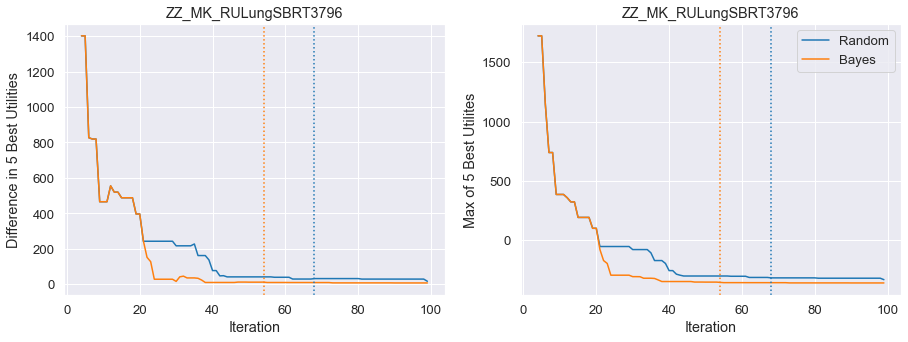

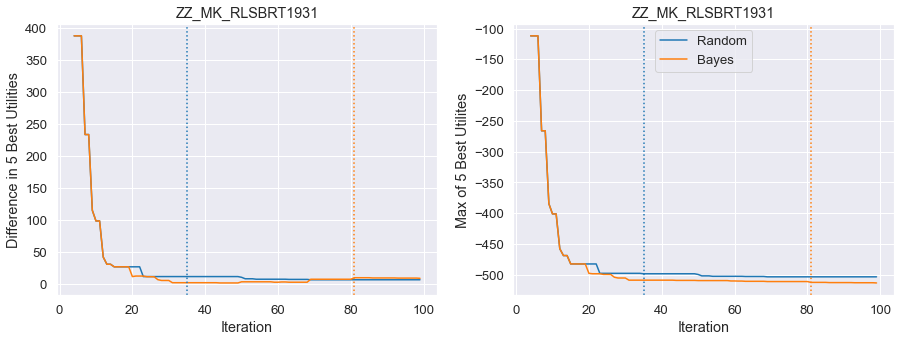

In [49]:
for folder in folders:
    plot_util_diff(folder)
    
# Left
# * skopt.callbacks.DeltaYStopper(delta, n_best=5)
#   is based on the n_best utilies being within delta
# * this is what I'm plotting in `Difference in 5 Best Utilities`
# * possibly better than using the difference in utility,
#   because you might stop too early

# Right
# * the worst of the best 5 utilities isn't useful for a
#   stopping condition, because we don't know what range
#   any of our values will fall into ahead of time

## Plot difference in n_best

In [10]:
# Maybe plot utility values vs. these various measures!

# What are the best candidates?
# * difference in utility
# * difference in best utilities (try different values of n_best?)

In [50]:
def get_diff_of_n_min(util_vec, n=5):
    result = []
    for ii in range(len(util_vec)):
        sub_vec = util_vec[:ii+1].copy()
        if len(sub_vec) < n:
            result.append(np.nan)
        else:
            sub_vec.sort()
            sub_vec = sub_vec[:n].copy()
            result.append(np.max(sub_vec) - np.min(sub_vec))
    return result

def plot_util_diff_n(folder, n):
    print(folder)
    
    # Load data
    bayes = np.load(folder + '/bayes/res_linquad_gp_minimize.pkl', allow_pickle=True)
    random = np.load(folder + '/bayes/res_linquad_dummy_minimize.pkl', allow_pickle=True)
    
    # Index of best point
    idx_random = np.argmin(random.opt_result.func_vals)
    idx_bayes = np.argmin(bayes.opt_result.func_vals)
    
    # Best utilities
    best_random = np.minimum.accumulate(random.opt_result.func_vals)
    best_bayes = np.minimum.accumulate(bayes.opt_result.func_vals)
    
    # Get differences
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))      
    diff_random = get_diff_of_n_min(random.opt_result.func_vals, n)
    diff_bayes = get_diff_of_n_min(bayes.opt_result.func_vals, n)

    # Plot difference in best utilities vs. iteration
    ax[0].plot(diff_random, c=my_cmap(0))
    ax[0].plot(diff_bayes, c=my_cmap(1))

    # Plot difference in best utilities vs. best utility
    ax[1].plot(best_random, diff_random, c=my_cmap(0))
    ax[1].plot(best_bayes, diff_bayes, c=my_cmap(1))

    # Idx where delta drops below 10
    ten_random = np.array(np.argwhere(np.array(diff_random) < 10)).squeeze()
    if len(ten_random) > 0:
        ten_20_random = np.argwhere(ten_random > 20)
        if len(ten_20_random) > 0:
            ten_20_random = ten_random[ten_20_random[0][0]]
            ax[0].plot(ten_20_random, diff_random[ten_20_random], 'o', c=my_cmap(0))
            ax[1].plot(best_random[ten_20_random], diff_random[ten_20_random], 'o', c=my_cmap(0))
            print(f"Random iter: {ten_20_random}, util: {best_random[ten_20_random]}")
        else:
            print(f"Random iter: {len(best_random)}, util: {best_random[-1]}")
    else:
        print(f"Random iter: {len(best_random)}, util: {best_random[-1]}")
    ten_bayes = np.array(np.argwhere(np.array(diff_bayes) < 10)).squeeze()
    if len(ten_bayes) > 0:
        ten_20_bayes = np.argwhere(ten_bayes > 20)
        if len(ten_20_bayes) > 0:
            ten_20_bayes = ten_bayes[ten_20_bayes[0][0]]
            ax[0].plot(ten_20_bayes, diff_bayes[ten_20_bayes], 'o', c=my_cmap(1))
            ax[1].plot(best_bayes[ten_20_bayes], diff_bayes[ten_20_bayes], 'o', c=my_cmap(1))
            print(f"Bayes iter: {ten_20_bayes}, util: {best_bayes[ten_20_bayes]}")
        else:
            print(f"Bayes iter: {len(best_bayes)}, util: {best_bayes[-1]}")
    else:
        print(f"Bayes iter: {len(best_bayes)}, util: {best_bayes[-1]}")
        
    # Plot location of best iterate
    ax[0].axvline(idx_random, color=my_cmap(0), linestyle=':')
    ax[0].axvline(idx_bayes, color=my_cmap(1), linestyle=':')
    
    # Annotations
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('Difference in N Best Utilities')
    ax[0].set_title(folder)
    ax[0].set_ylim([0, 50])
    ax[1].set_xlabel('Best Utility')
    ax[1].set_ylabel('Difference in N Best Utilites')
    ax[1].set_title(folder)
    ax[1].set_ylim([0, 50])
    ax[1].legend(['Random', 'Bayes'])
    print()

SBRT_lung_minsun
Random iter: 21, util: -436.31821716927027
Bayes iter: 39, util: -473.3752117072215

ZZ_MK_LLungSBRT3778
Random iter: 100, util: -427.2048658457759
Bayes iter: 50, util: -390.5993564187497

ZZ_MK_RLungSBRT4076
Random iter: 68, util: -476.6586004054677
Bayes iter: 23, util: -464.01968755414464

ZZ_MK_RULungSBRT3796
Random iter: 100, util: -351.71222148714355
Bayes iter: 38, util: -360.6485825151348

ZZ_MK_RLSBRT1931
Random iter: 51, util: -509.922258518126
Bayes iter: 27, util: -510.7503315855113



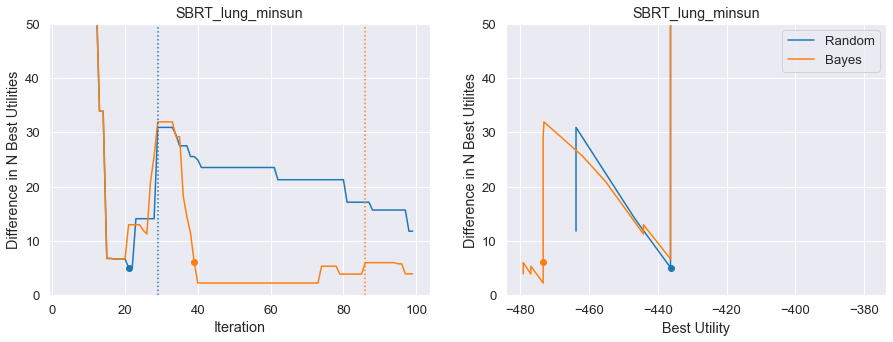

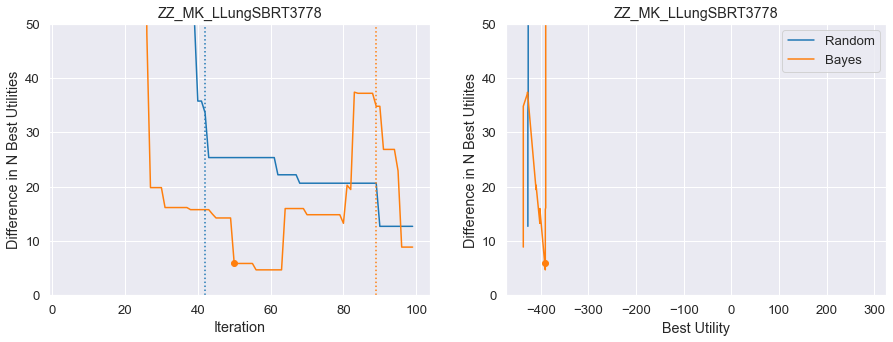

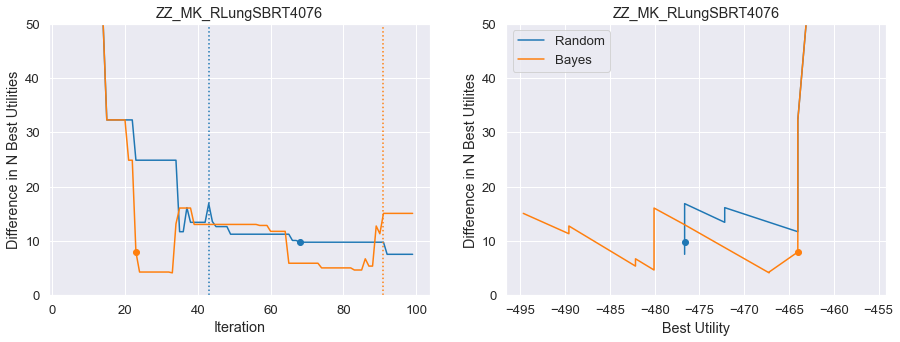

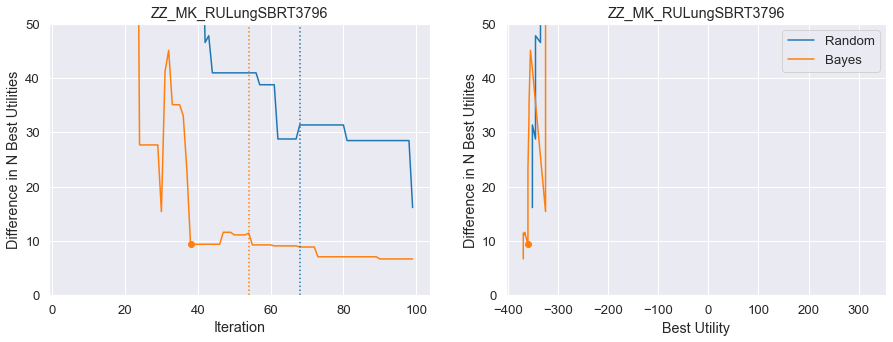

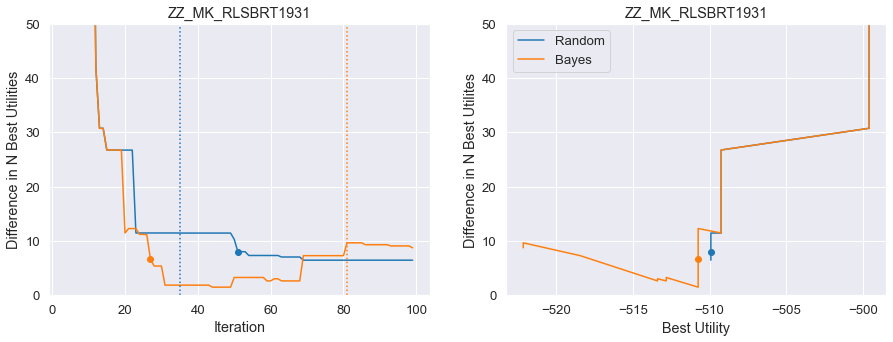

In [51]:
for folder in folders:
    plot_util_diff_n(folder, n=5)
    
# What about:
# * n_best = 5
# * delta = 10
# * iter > 20

# don't need to re-run to get goal values, but do need to for the dvh curves
# can get timing from the logs, but might not be precies

In [52]:
def plot_iter_util(folder):
    # Load data
    bayes = np.load(folder + '/bayes/res_linquad_gp_minimize.pkl', allow_pickle=True)
    random = np.load(folder + '/bayes/res_linquad_dummy_minimize.pkl', allow_pickle=True)
    
    # Best current utilities
    best_random = np.minimum.accumulate(random.opt_result.func_vals)
    best_bayes = np.minimum.accumulate(bayes.opt_result.func_vals)
    
    # Best utilies
    opt_random = random.opt_result.fun
    opt_bayes = bayes.opt_result.fun
    
    # Index of best utilities
    idx_random = np.argmin(best_random)
    idx_bayes = np.argmin(best_bayes)
    
    # Decrease in utilities
    util_random = [100*ii/opt_random for ii in best_random]
    util_bayes = [100*ii/opt_bayes for ii in best_bayes]
    
    # Iterations
    iter_vals = np.arange(len(best_random))
    
    # Decrease in iterations
    iter_random = [100*ii/idx_random for ii in iter_vals]
    iter_bayes = [100*ii/idx_bayes for ii in iter_vals]
    
    # Plot results
    plt.figure()
    plt.plot(iter_random, util_random, c=my_cmap(0))
    plt.plot(iter_bayes, util_bayes, c=my_cmap(1))
    plt.xlabel('Percent of best iterations')
    plt.ylabel('Percent of best utility')
    plt.title(folder)
    plt.legend(['Random', 'Bayes'])
#     plt.axvline(idx_random, linestyle=':', color=my_cmap(0))
#     plt.axvline(idx_bayes, linestyle=':', color=my_cmap(1))
    plt.axhline(95, linestyle=':', color='gray')
    plt.ylim([-10, 110])

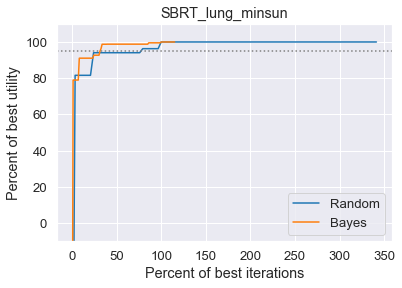

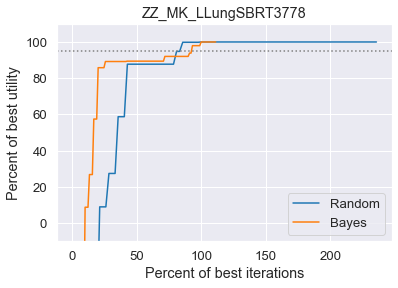

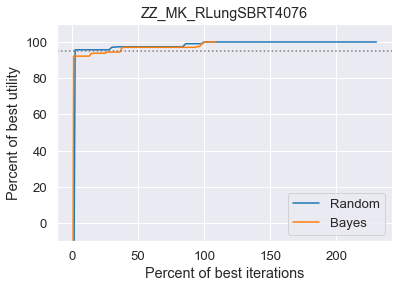

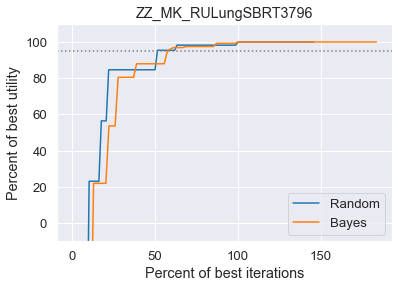

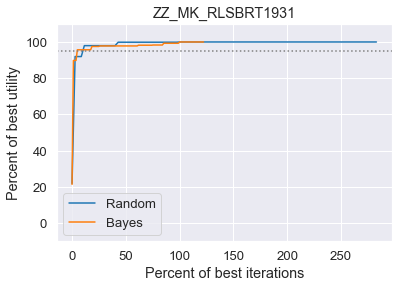

In [53]:
for folder in folders:
    plot_iter_util(folder)

## Candidate 1

Default 20 iterations, then stop once the % difference of the average of the 10 best is below 5%.

Hyperparameters:
* Default iterations
* Number of best values to consider
* Percent difference tolerance (e.g., is 5% good enough, or should it be 1%?)

This stopping condition exits too early, because it the utility doesn't always improve each iteration.
When

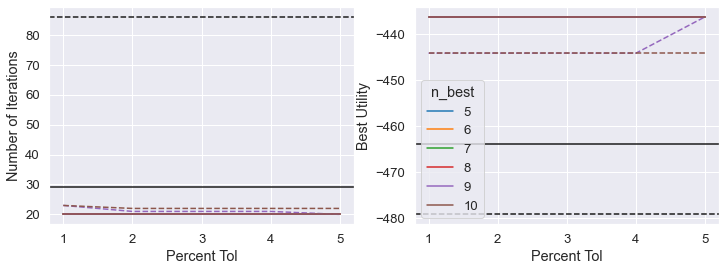

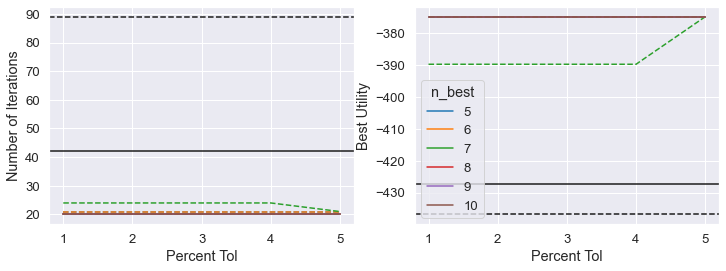

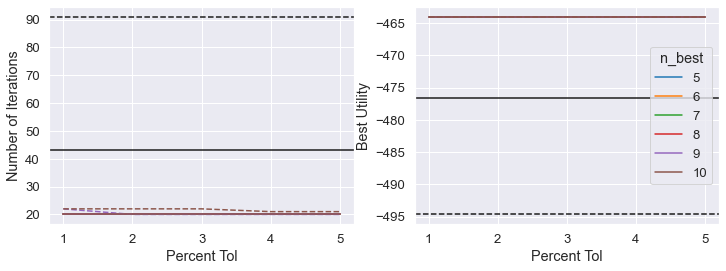

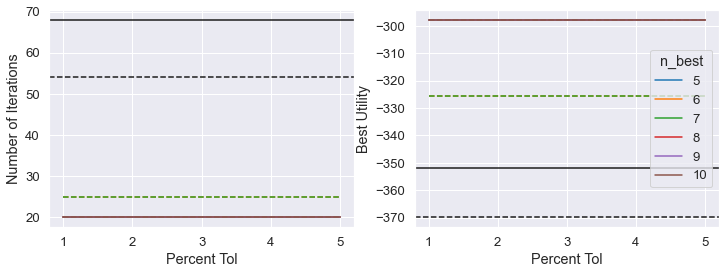

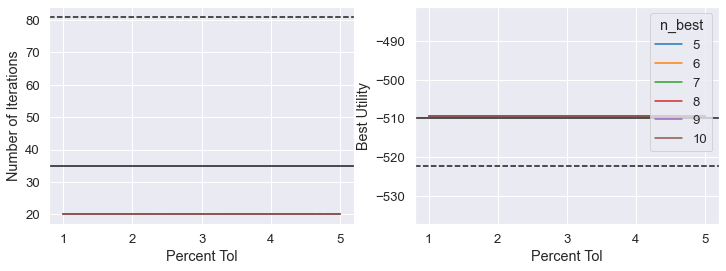

In [128]:
# Compare utilities with stopping condition and hyperparameters

def get_avg_n_min(util_vec, n=5):
    result = []
    for ii in range(len(util_vec)):
        sub_vec = util_vec[:ii+1].copy()
        if len(sub_vec) < n:
            result.append(np.nan)
        else:
            sub_vec.sort()
            sub_vec = sub_vec[:n].copy()
            result.append(np.mean(sub_vec))
    return result


n_default = 20
for folder in folders:
    # Load data
    random = np.load(folder + '/bayes/res_linquad_dummy_minimize.pkl', allow_pickle=True)
    bayes = np.load(folder + '/bayes/res_linquad_gp_minimize.pkl', allow_pickle=True)
    
    # Index of best point
    idx_random = np.argmin(random.opt_result.func_vals)
    idx_bayes = np.argmin(bayes.opt_result.func_vals)
    
    best_random = np.minimum.accumulate(random.opt_result.func_vals)
    best_bayes = np.minimum.accumulate(bayes.opt_result.func_vals)

    n_best = np.arange(5, 11)
    percent_tol = np.arange(1, 6)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    for ii, n in enumerate(n_best):
        iter_vals = [[], []]
        util_vals = [[], []]
        for tol in percent_tol:
            # Average of n best utility values
            avg_random = get_avg_n_min(random.opt_result.func_vals, n)
            avg_bayes = get_avg_n_min(bayes.opt_result.func_vals, n)
            
            # Percent difference from previous iteration
            diff_random = [np.nan] + [100*(avg_random[ii] - avg_random[ii - 1])/avg_random[ii - 1]
                                      for ii in range(1, len(avg_random))]
            diff_bayes = [np.nan] + [100*(avg_bayes[ii] - avg_bayes[ii - 1])/avg_bayes[ii - 1]
                                     for ii in range(1, len(avg_bayes))]

            # Get index last iteration
            try:
                iter_vals[0].append(np.where(np.array(diff_random[n_default:]) < tol)[0][0] + n_default)
            except:
                iter_vals[0].append(99)
            try:
                iter_vals[1].append(np.where(np.array(diff_bayes[n_default:]) < tol)[0][0] + n_default)
            except:
                iter_vals[1].append(99)

            # Get utility at last iteration
            util_vals[0].append(best_random[iter_vals[0][-1]])
            util_vals[1].append(best_bayes[iter_vals[1][-1]])
        ax[0].plot(percent_tol, iter_vals[0], c=my_cmap(ii))
        ax[0].plot(percent_tol, iter_vals[1], '--', c=my_cmap(ii))
        ax[1].plot(percent_tol, util_vals[0], c=my_cmap(ii), label=n)
        ax[1].plot(percent_tol, util_vals[1], '--', c=my_cmap(ii))

    ax[0].axhline(idx_random, color='k')
    ax[0].axhline(idx_bayes, color='k', linestyle='--')
    ax[0].set_xlabel('Percent Tol')
    ax[0].set_ylabel('Number of Iterations')

    ax[1].axhline(random.opt_result.fun, color='k')
    ax[1].axhline(bayes.opt_result.fun, color='k', linestyle='--')
    ax[1].set_xlabel('Percent Tol')
    ax[1].set_ylabel('Best Utility')
    ax[1].legend(title='n_best')

## Candidate 2

Default 20 iterations, then stop once the % difference between the best and worse in the top 10 is below 5%

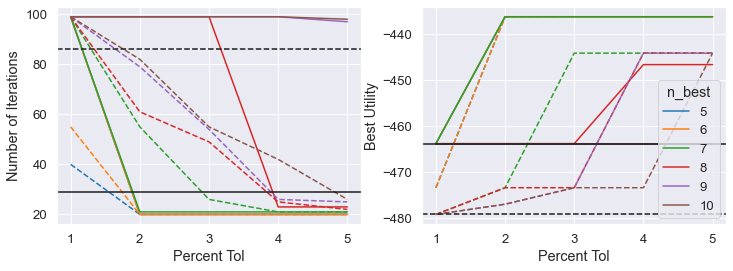

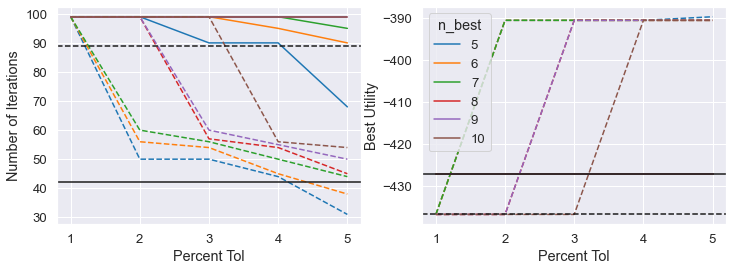

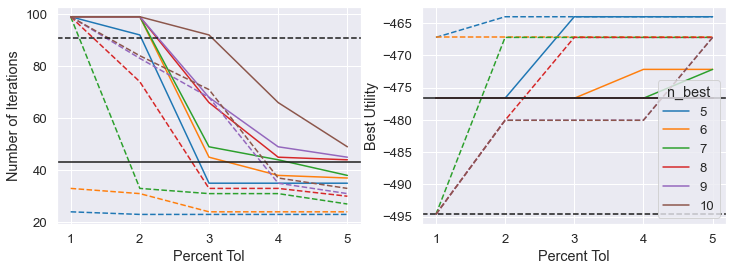

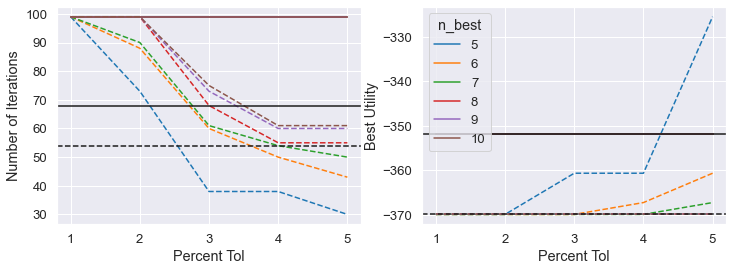

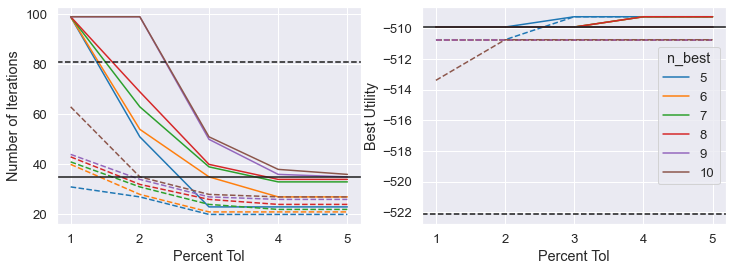

In [120]:
# Compare utilities with stopping condition and hyperparameters

def get_percent_diff_of_n_min(util_vec, n=5):
    # expects the best to be the most negative
    result = []
    for ii in range(len(util_vec)):
        sub_vec = util_vec[:ii+1].copy()
        if len(sub_vec) < n:
            result.append(np.nan)
        else:
            sub_vec.sort()
            sub_vec = sub_vec[:n].copy()
            min_val = min(sub_vec)
            max_val = max(sub_vec)
            result.append(100*(min_val - max_val)/min_val)
    return result


n_default = 20
for folder in folders:
    # Load data
    random = np.load(folder + '/bayes/res_linquad_dummy_minimize.pkl', allow_pickle=True)
    bayes = np.load(folder + '/bayes/res_linquad_gp_minimize.pkl', allow_pickle=True)
    
    # Index of best point
    idx_random = np.argmin(random.opt_result.func_vals)
    idx_bayes = np.argmin(bayes.opt_result.func_vals)
    
    best_random = np.minimum.accumulate(random.opt_result.func_vals)
    best_bayes = np.minimum.accumulate(bayes.opt_result.func_vals)

    n_best = np.arange(5, 11)
    percent_tol = np.arange(1, 6)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    for ii, n in enumerate(n_best):
        iter_vals = [[], []]
        util_vals = [[], []]
        for tol in percent_tol:
            # Percent difference in best utilities
            diff_random = get_percent_diff_of_n_min(random.opt_result.func_vals, n)
            diff_bayes = get_percent_diff_of_n_min(bayes.opt_result.func_vals, n)

            # Get index last iteration
            try:
                iter_vals[0].append(np.where(np.array(diff_random[n_default:]) < tol)[0][0] + n_default)
            except:
                iter_vals[0].append(99)
            try:
                iter_vals[1].append(np.where(np.array(diff_bayes[n_default:]) < tol)[0][0] + n_default)
            except:
                iter_vals[1].append(99)

            # Get utility at last iteration
            util_vals[0].append(best_random[iter_vals[0][-1]])
            util_vals[1].append(best_bayes[iter_vals[1][-1]])
        ax[0].plot(percent_tol, iter_vals[0], c=my_cmap(ii))
        ax[0].plot(percent_tol, iter_vals[1], '--', c=my_cmap(ii))
        ax[1].plot(percent_tol, util_vals[0], c=my_cmap(ii), label=n)
        ax[1].plot(percent_tol, util_vals[1], '--', c=my_cmap(ii))

    ax[0].axhline(idx_random, color='k')
    ax[0].axhline(idx_bayes, color='k', linestyle='--')
    ax[0].set_xlabel('Percent Tol')
    ax[0].set_ylabel('Number of Iterations')

    ax[1].axhline(random.opt_result.fun, color='k')
    ax[1].axhline(bayes.opt_result.fun, color='k', linestyle='--')
    ax[1].set_xlabel('Percent Tol')
    ax[1].set_ylabel('Best Utility')
    ax[1].legend(title='n_best')
    
# How to read:
# * Each row is a different patient
# * Solid lines are random plans, dashed lines are Bayesian plans
# * Colors correspond to how many best utilities were used
# * Horizontal axis is the percent difference used in the stopping condition
# * Black is the best utility after 100 iterations

# Trends: 
# * As percent difference decreases, meeting the stopping condition becomes more difficult
#   - Number of iterations increases
#   - Best utility increases (or decreases, since here lower is better)
# * As number of best plans included increases, meeting the stopping condition becomes more difficult
#   - Same as before: more iterations, better utility

# Question: How many best plans and what tolerance?